## Create price curve and plot it

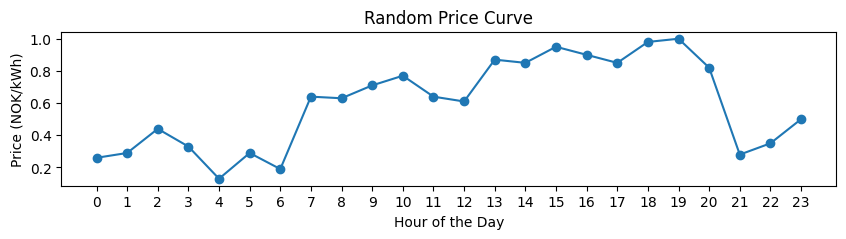

In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np

def generate_price_curve(peak_hours, morning_hours):
    price_curve = {}
    for hour in range(24):
        if hour in peak_hours:
            price_curve[hour] = round(random.uniform(0.8, 1.0), 2)  # Peak price range: 0.2 to 1.0 NOK/kWh
        elif hour in morning_hours:
            price_curve[hour] = round(random.uniform(0.6, 0.8), 2)
        else:
            price_curve[hour] = round(random.uniform(0.1, 0.5), 2)  # Default to off-peak price for non-defined hours
    return price_curve

# Define peak and off-peak hours (for example)
peak_hours = {13, 14, 15, 16, 17, 18, 19, 20}  # 5:00 pm to 8:00 pm
morning_hours = {7, 8, 9, 10, 11, 12}

# Generate a random price curve
price_curve = generate_price_curve(peak_hours, morning_hours)

# Plot the generated price curve
plt.figure(figsize=(10, 2))
plt.plot(price_curve.keys(), price_curve.values(), marker='o', linestyle='-')
plt.title("Random Price Curve")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (NOK/kWh)")
plt.grid(False)
plt.xticks(range(24))
plt.show()


## Problem 2

In [19]:
import pyomo.environ as pe

l_h = 2/10 #hourly consumption of lighting kWh
h_h = 9.6/24 #hourly consumption of heating kWh
r_h = 3.96/24 #hourly consumption of refrigerator kWh
s_h = 3.9/2 #hourly consumption of stove kWh
tv_h = 0.6/5 #hourly consumption of refrigerator kWh
pc_h = 0.6/2 #hourly consumption of pc kWh

#Energy consumption for non-shiftable appliances per appliance, per hour kWh
x_ns = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, 0, 0, 0, 0],
        [h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h],
        [r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,s_h,s_h,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tv_h,tv_h,tv_h,tv_h,tv_h,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pc_h,pc_h,0,0,0,0,0]])

E = [1.44, 1.94, 2.5, 9.9] #daily energy consumption of the 4 shiftable appliances

m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers)
m.T     = pe.Set(initialize = range(m.nt()))
m.price = pe.Param(m.T, initialize = price_curve)
m.I     = pe.RangeSet(0,len(E)-1)

m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t

# Define objective function
def obj_rule(model):
    total_cost = 0
    # Add cost of non-shiftable appliances
    for t in model.T:
        total_cost += model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns))))
    return total_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  #add constraints to the list created above
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) 
  
results = pe.SolverFactory('cbc').solve(m)

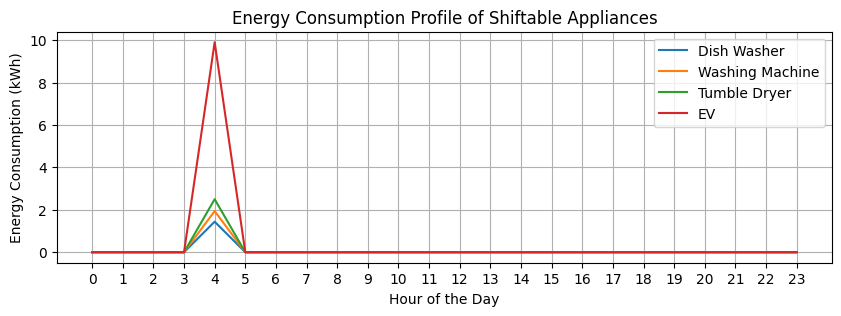

In [20]:
# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

app_names = ['Dish Washer', 'Washing Machine', 'Tumble Dryer','EV']

# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
plt.title("Energy Consumption Profile of Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.show()